In [106]:

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import sounddevice as sd
from scipy.io import wavfile
from scipy import signal
from pydub import AudioSegment


Книга 

http://www.dspguide.com/about.htm

Образцы звуков

https://freewavesamples.com/

Документация в помощь

https://www.kaggle.com/code/ilyamich/mfcc-implementation-and-tutorial

https://prosound.ixbt.com/education/spektr-analys.shtml

https://opensource.com/article/19/9/audio-processing-machine-learning-python


Некоторые важные функции и преобразования данных, важные для обработки речи и звука:

1. Mel-frequency cepstral coefficients (MFCCs) Мел-кепстральные коэффициенты
1. Gammatone-frequency cepstral coefficients (GFCCs) Гамматон-частотные кепстральные коэффициенты
1. Linear-prediction cepstral coefficients (LFCCs)  Линейно-частотные кепстральных коэффициентов
1. Bark-frequency cepstral coefficients (BFCCs) 
1. Power-normalized cepstral coefficients (PNCCs) Нормированные по мощности кепстральные коэффициенты
1. Spectrum  Спектр
1. Sepstrum  Kепстр
1. Spectrogram  Cпектрограмма

# Что такое спектр и кепстр?

Спектр и кепстр — две особенно важные функции обработки звука.

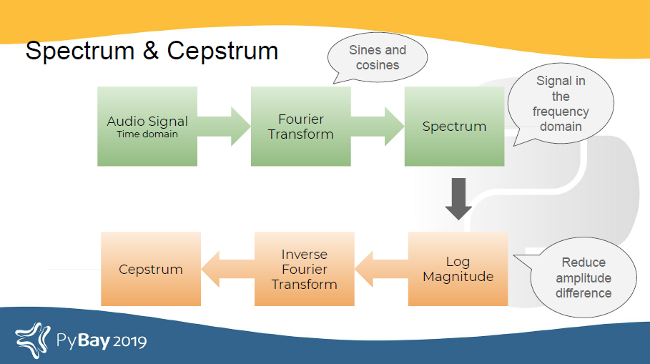

Математически спектр — это преобразование Фурье сигнала. Преобразование Фурье преобразует сигнал временной области в частотную область. Другими словами, спектр — это представление в частотной области входного аудиосигнала во временной области.

Кепстр формируется путем взятия логарифмической величины спектра с последующим обратным преобразованием Фурье. В результате получается сигнал, который не находится ни в частотной области (поскольку мы использовали обратное преобразование Фурье), ни во временной области (поскольку мы взяли логарифмическую величину до обратного преобразования Фурье). Область результирующего сигнала называется квенренцией.


Причина, по которой нас волнует сигнал в частотной области, связана с биологией уха. Прежде чем мы сможем обрабатывать и интерпретировать звук, должно произойти много вещей. Один из них происходит в улитке — заполненной жидкостью части уха с тысячами крошечных волосков, связанных с нервами. Некоторые волоски короткие, а некоторые относительно длиннее. Более короткие волосы резонируют с более высокими звуковыми частотами, а более длинные — с более низкими звуковыми частотами. Таким образом, ухо похоже на естественный анализатор с преобразованием Фурье!

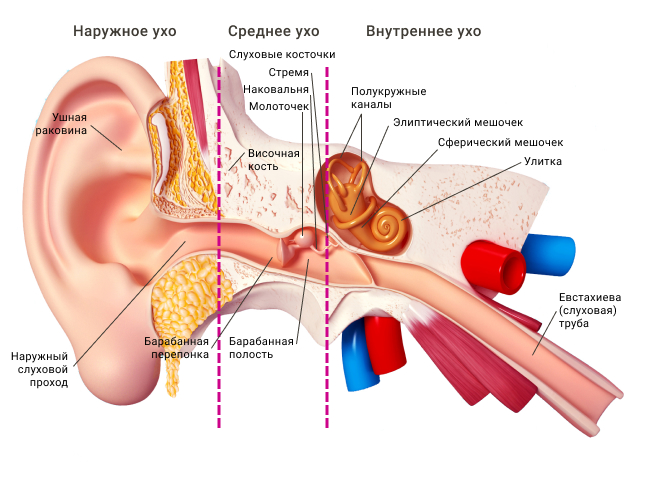

Еще один факт о человеческом слухе заключается в том, что по мере увеличения частоты звука выше 1 кГц наши уши становятся менее избирательными к частотам. Это хорошо соответствует так называемому банку фильтров Мела.

А вообще мы можем слышать только в диапазоне частот от 20 до 20000 Hz


In [12]:
f = 'data/Alesis-S4-Plus-Clean-Gtr-C4.wav'


samplerate, data = wavfile.read(f)
print('Sampling Rate:',samplerate)
print('Audio Shape:',np.shape(data))

Sampling Rate: 44100
Audio Shape: (69132, 2)


C:\Users\Mi\AppData\Local\Temp\ipykernel_62372\3911317354.py:4: WavFileWarning: Chunk (non-data) not understood, skipping it.
  samplerate, data = wavfile.read(f)


samplerate - частота дискретизации (или частота семплирования, англ. sample rate) — частота взятия отсчётов непрерывного по времени сигнала при его дискретизации (в частности, аналого-цифровым преобразователем). Измеряется в герцах.

In [13]:
duration = len(data)/samplerate
time = np.arange(0,duration,1/samplerate) #time vector

print(f"длительность {duration} \n временная шкала {time}")

длительность 1.5676190476190477 
 временная шкала [0.00000000e+00 2.26757370e-05 4.53514739e-05 ... 1.56755102e+00
 1.56757370e+00 1.56759637e+00]


In [14]:
type(data)

numpy.ndarray

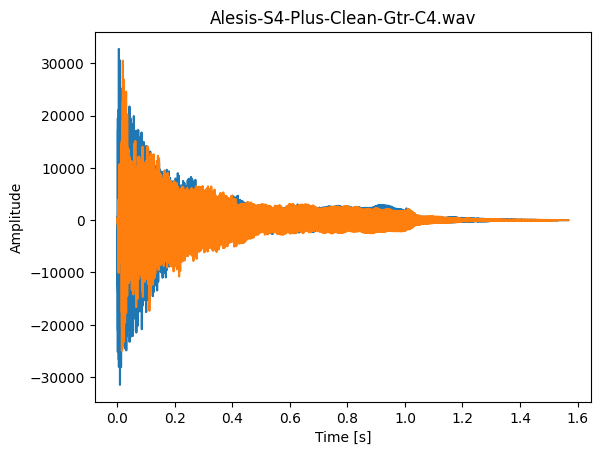

In [108]:

plt.plot(time, data)
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('Alesis-S4-Plus-Clean-Gtr-C4.wav')
plt.show()

In [107]:
# слушаем, что получилось
sd.play(data[:, 0], samplerate)
sd.wait()

## Stereo to Mono

Sampling Rate: 44100
Audio Shape: (69132,)


C:\Users\Mi\AppData\Local\Temp\ipykernel_62372\1947633516.py:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(t,a,'k-',color='purple')


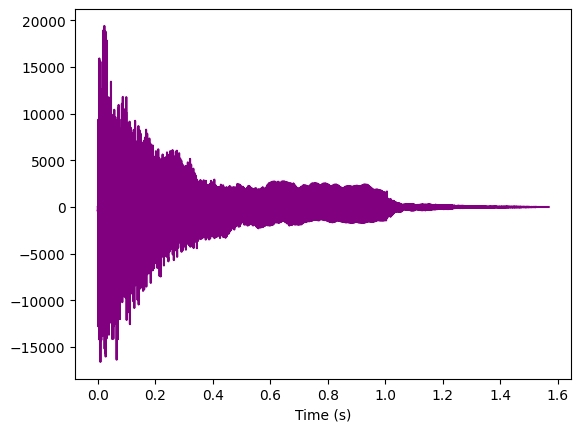

In [109]:
asegment = AudioSegment.from_wav(f)
asegment = asegment.set_channels(1)
asegment.export("mono.wav",format="wav")

s,a = wavfile.read("mono.wav")
print('Sampling Rate:',s)
print('Audio Shape:',np.shape(a))

duration = len(data)/samplerate
time = np.arange(0,duration,1/samplerate) #time vector

na = data.shape[0]
la = na / s
t = np.linspace(0,la,na)
plt.plot(t,a,'k-',color='purple')
plt.xlabel('Time (s)')
plt.show()

 

# Спектрограмма

Спектрограмма - зависимость спектральной плотности мощности сигнала от времени. Она отображает мощность частоты в каждом временном отрезке. Естественный логарифм спектрограммы улучшает видимость частотного содержания, так что несколько больших пиков не снижают разрешение всей спектрограммы.

Спектрограмма  - двумерная диаграмма: 

на горизонтальной оси представлено время, по вертикальной оси — частота; третье измерение с указанием амплитуды на определенной частоте в конкретный момент времени представлено интенсивностью или цветом каждой точки изображения.

Спектрограмма сигнала s(t) может быть оценена путём вычисления квадрата амплитуды оконного преобразования Фурье сигнала s(t), следующим образом:

$
{\mathrm  {spectrogram}}(t,\omega )=\left|{\mathrm  {STFT}}(t,\omega )\right|^{2}
$

Создание спектрограммы с помощью оконного преобразования Фурье обычно выполняется методами цифровой обработки. Производится цифровая выборка данных во временной области. Сигнал разбивается на части, которые, как правило, перекрываются, и затем производится преобразование Фурье, чтобы рассчитать величину частотного спектра для каждой части. Каждая часть соответствует вертикальной линии на изображении — значение амплитуды в зависимости от частоты в каждый момент времени.

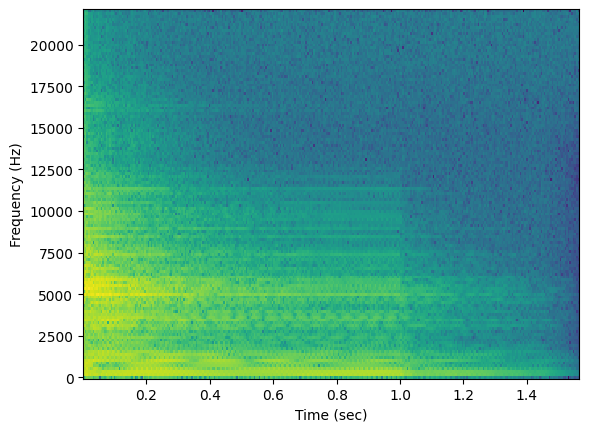

In [21]:
adata = data[:, 0]
s = samplerate

fr, tm, spgram = signal.spectrogram(adata,s)
lspg = np.log(spgram)
plt.pcolormesh(tm,fr,lspg,shading='auto')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (sec)')
plt.show()

# Быстрое преобразование Фурье (FFT)

Быстрое преобразование Фурье (FFT) – алгоритм, который позволяет вычислить частотный спектр сигнала.
Это один из алгоритмов вычисления дискретного преобразования Фурье.

Нужны 2 функции:

fft() вычисляет быстрое преобразование Фурье.

fftfreq() находит частоты в центре каждого «бина» на выходе fft(). Бин - интервал группировки значений.

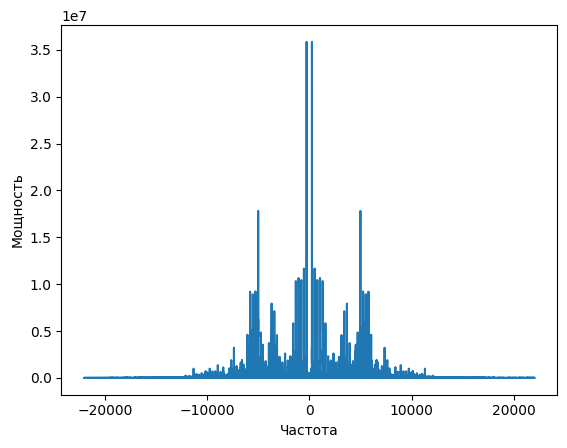

In [104]:
from scipy.fft import fft, fftfreq

# число точек в normalized_tone
N = int(samplerate * duration)

yf = fft(data[:, 0])
xf = fftfreq(N, 1 / samplerate)

plt.plot(xf, np.abs(yf))
plt.xlabel('Частота')
plt.ylabel('Мощность')
plt.show()

Максимальная частота - 22050 Гц. Это значение составляет ровно половину частоты дискретизации и называется *частотой Найквиста*.

Это соответствует фундаментальной теореме обработки сигналов (теорема Котельникова, теорема Найквиста — Шеннона, теорема отсчётов):

**Любую функцию F(t), состоящую из частот от 0 до 1 до f_1, можно непрерывно передавать с любой точностью при помощи чисел, следующих друг за другом менее чем через  1/(2f_1) секунд.**

 То есть частота дискретизации должна как минимум вдвое превышать максимальную частоту сигнала.

In [105]:
np.max(xf)

22049.362089914943

In [110]:
samplerate

44100

Частотный спект получился симметричным. То есть можно вычислить только одну часть частотного спектра.

Это можно сделать с помощью функции rfft().



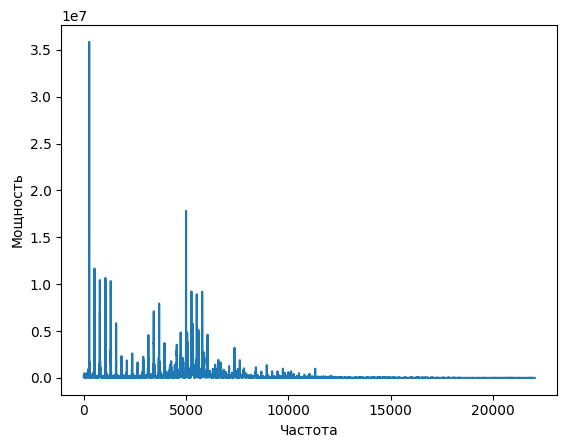

In [113]:
from scipy.fft import rfft, rfftfreq

# число точек в normalized_tone
rN = int(samplerate * duration)

ryf = rfft(data[:, 0])
rxf = rfftfreq(rN, 1 / samplerate)

plt.plot(rxf, np.abs(ryf))
plt.xlabel('Частота')
plt.ylabel('Мощность')
plt.show()

 Преобразовании Фурье обратимо. Любой сигнал, измененный в частотной области, можно преобразовать обратно во временную область.

 Это можно использовать для фильтрации сигнала. 

 Попробуем отфильтровать частоту 4998.663426488456 Гц

In [114]:
# Максимальная частота составляет половину частоты дискретизации
points_per_freq = len(rxf) / (samplerate / 2)

# Наша целевая частота 
target_idx = int(points_per_freq * 4998.663426488456)

target_idx1 = int(points_per_freq * 10000)

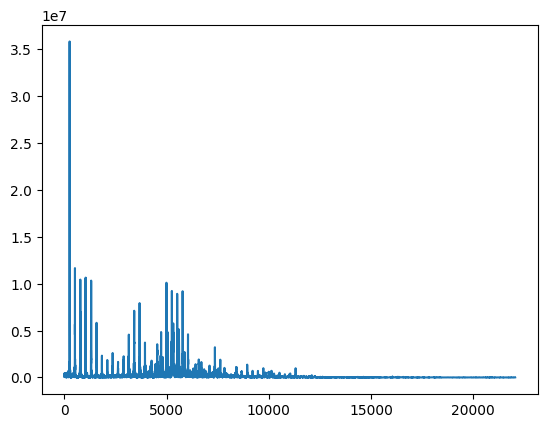

In [115]:
ryf[target_idx-2:target_idx+2] = 0


plt.plot(rxf, np.abs(ryf))
plt.show()

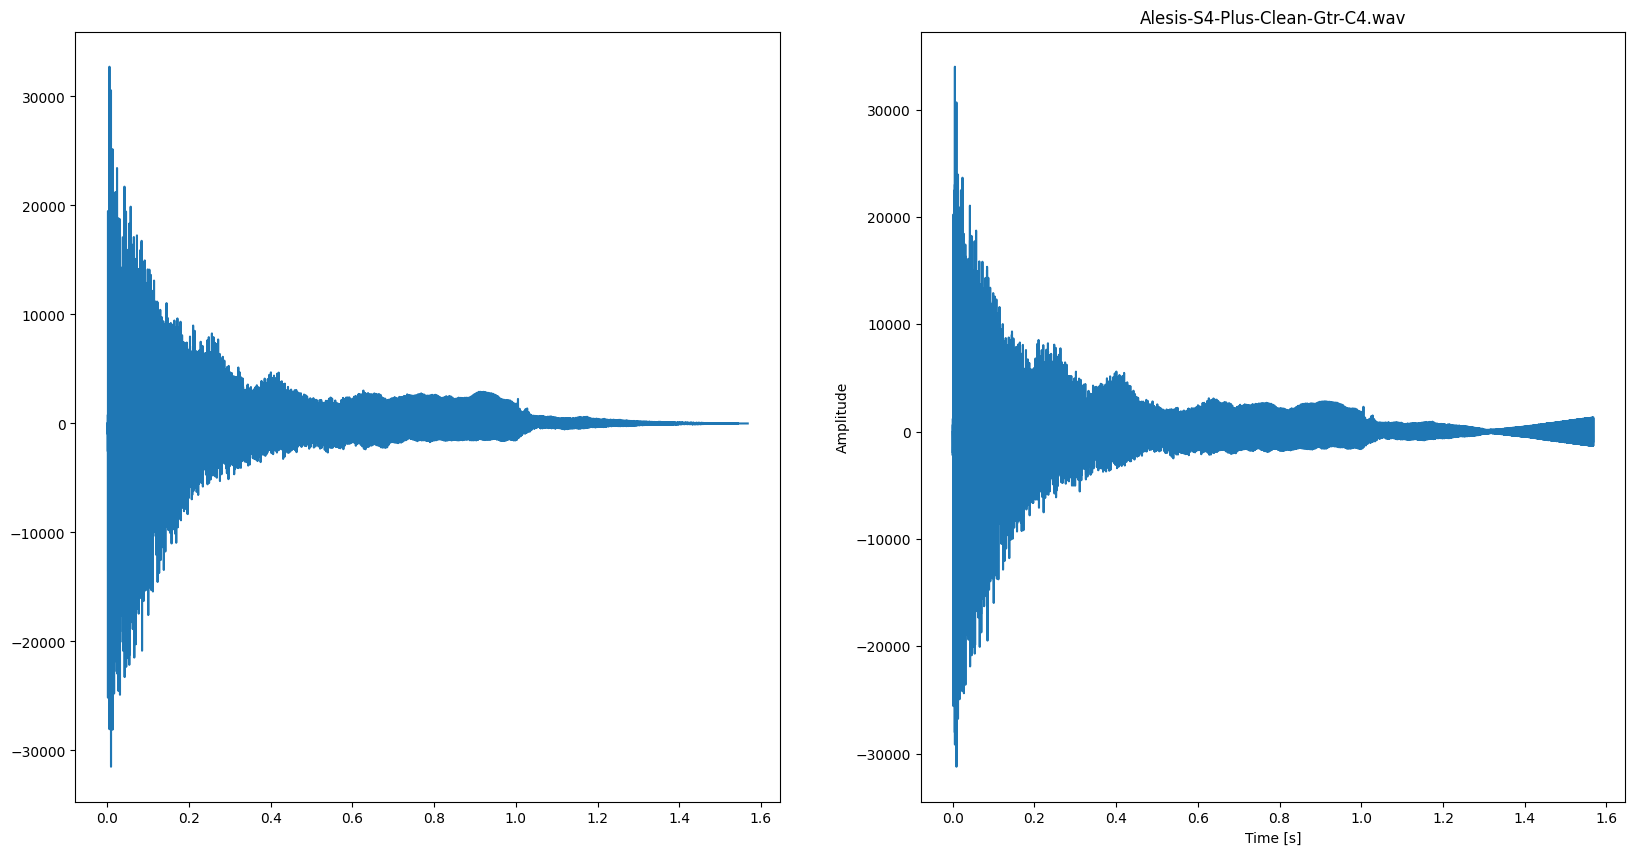

In [116]:
from scipy.fft import irfft

new_sig = irfft(ryf)

fig, ax = plt.subplots(nrows= 1 , ncols= 2, figsize=(20, 10) )

ax[0].plot(time, data[:, 0])
ax[1].plot(time, new_sig)
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('Alesis-S4-Plus-Clean-Gtr-C4.wav')
plt.show()

In [117]:
# слушаем, что получилось
sd.play(data[:, 0], samplerate)
sd.wait()

sd.play(new_sig, samplerate)
sd.wait()


# Дискретное косинусное преобразование   (англ. Discrete Cosine Transform, DCT)
Один из видов FFT

 Используется
 Обработка аудиосигнала — кодирование звука, сжатие аудиоданных (с потерями и без них), объемный звук, акустическое эхо и отмена обратной связи, фонема распознавание, отмена сглаживания во временной области (TDAC)
   1. Цифровой звук
   1. Цифровое радио — Цифровое звуковое вещание (DAB+), HD-радио
   1. Обработка речи — кодирование речи, распознавание речи, обнаружение голосовой активности (VAD)
   1. Цифровая телефония — передача голоса по IP (VoIP), мобильная телефония, видеотелефония, телеконференции, видеоконференции


А также во многих других областях - в работе с видео и изображениями, криптографии, биометрии, медицинских данных, и т.д.

Как и любое преобразование, связанное с Фурье, дискретные косинусоидальные преобразования (DCT) выражают функцию или сигнал в терминах суммы синусоид с различными частотами и амплитудами. Подобно дискретному преобразованию Фурье (DFT), DCT оперирует функцией с конечным числом дискретных точек данных. Очевидное различие между DCT и DFT заключается в том, что первое использует только косинусные функции, в то время как второе использует как косинусы, так и синусы (в форме комплексных экспонент). Однако это видимое различие является всего лишь следствием более глубокого различия: DCT подразумевает граничные условия, отличные от DFT или других связанных преобразований.

Связанные с Фурье преобразования, которые воздействуют на функцию в конечной области, такие как DFT или DCT или ряд Фурье, можно рассматривать как неявно определяющие расширение этой функции за пределы области. То есть, как только вы записываете функцию f(x) в виде суммы синусоид, вы можете вычислить эту сумму в любое время x, даже для x тех f(x) случаев, когда исходное значение не было указано. DFT, как и ряд Фурье, подразумевает периодическое расширение исходной функции. DCT, как и косинусное преобразование, подразумевает четное расширение исходной функции.

Формально дискретное косинусное преобразование является линейной обратимой функцией 
$
{\displaystyle f:\mathbb {R} ^{N} \to \mathbb {R} ^{N}} 
$
(где 
$
{\displaystyle \mathbb {R} } $ обозначает множество действительных чисел) или, что эквивалентно, обратимой N × N квадратной матрицей. Существует несколько вариантов DCT со слегка измененными определениями. N действительных чисел $
{\displaystyle ~x_{0},\ \ldots \ x_{N-1}~}$ преобразуются в N действительных чисел 
$
{\displaystyle X_{0},\,\ldots,\,X_{N-1}}$ в соответствии с одной из формул:

DCT - I

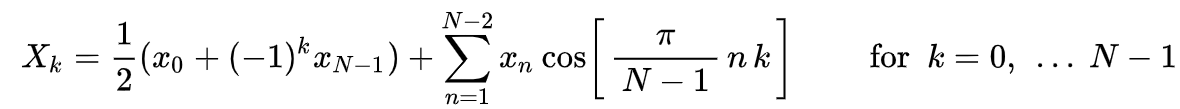

DCT - II

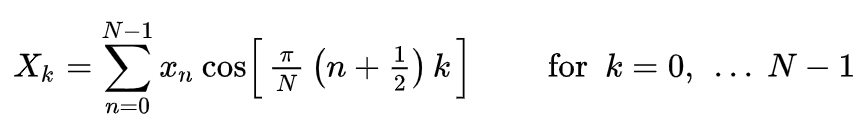

DCT - III

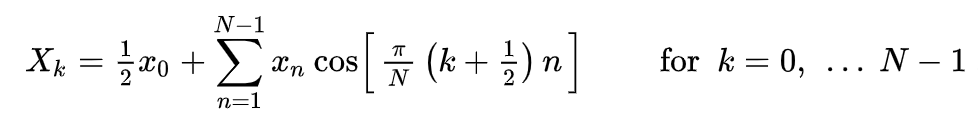

DCT - IV

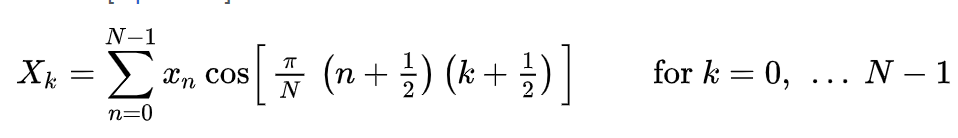

# Мел-кепстральные коэффициенты (MFCC)

Мел – единица высоты звука, основанная на восприятии этого звука нашими органами слуха. Как известно, АЧХ человеческого уха даже отдаленно не напоминает прямую, и амплитуда – не совсем точная мера громкости звука. Поэтому, и ввели эмпирически подобранные единицы громкости, например, фон


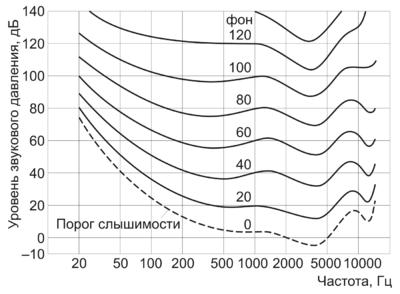

Воспринимаемая человеческим слухом высота звука не совсем линейно зависит от его частоты.

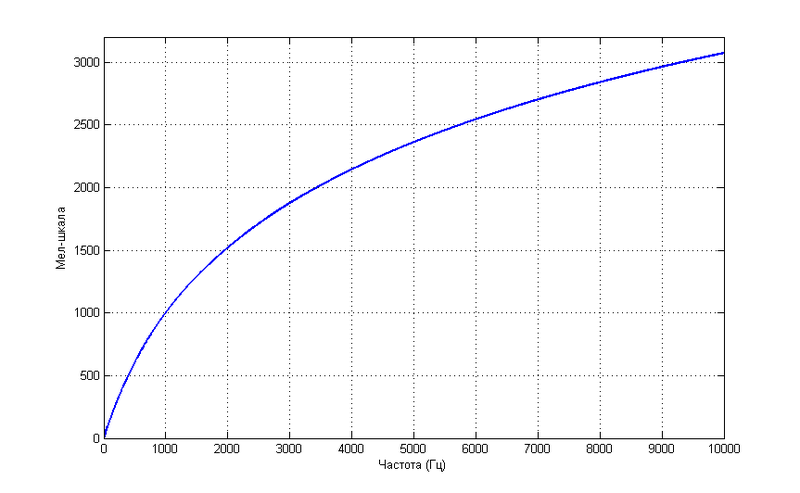
 
m = 1125 ln(1 + f/700)

# Кепстр

Кепстр — один из видов гомоморфной обработки сигналов, функция обратного преобразования Фурье от логарифма спектра мощности сигнала


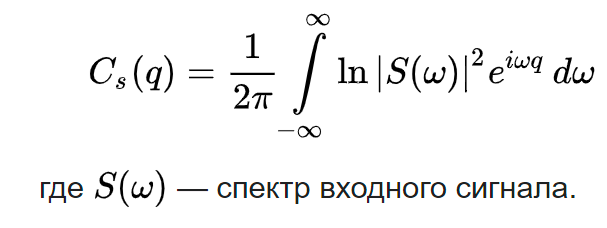

где $ S(\omega ) $— спектр входного сигнала.

Аргумент q имеет размерность времени, но это особое, кепстральное время, поскольку 
$
{\displaystyle C_{s}(q)}$ в любой момент  q зависит от функции $
{\displaystyle s(t)}$ исходного сигнала со спектром ${\displaystyle S(\omega ),}$ заданной при ${\displaystyle -\infty <t<\infty }$ 

Иногда q называют «сачтота» или «кьюфренси» (анаграммы от рус. частота или англ. frequency).

# Как получить мел-коэффициенты?


1. Исходный сигнал



2. Преобразовние Фурье

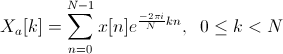

3. Гребенка фильтров на основе оконной функции

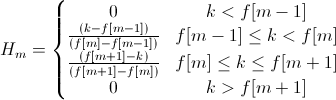

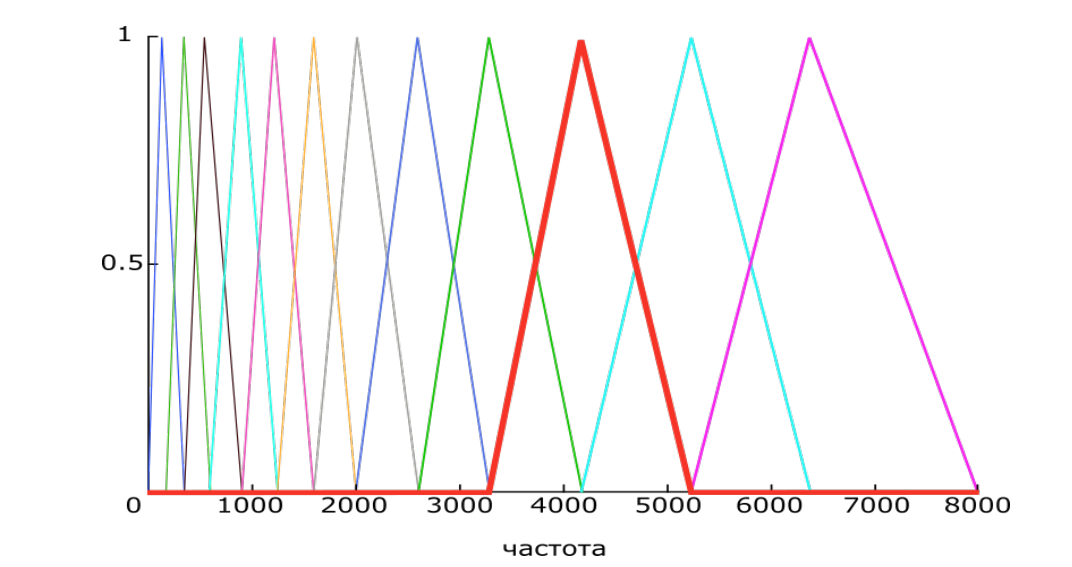
Фильтры собираются в области низких частот, обеспечивая более высокое "разрешение" там, где это
необходимо для распознавания

Частоты получаются на основе формул

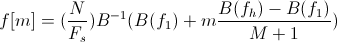

m - номер окна

M - количество окон

f1 - самая низкая частота проектного фильтра

fn - самая высокая частота проектного фильтра

Fs - частота дискретизации

Преобразование в мел-шкалу



4.  Вычисляем энергию для каждого окна

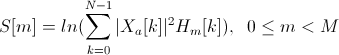


5. Применяем ДКП

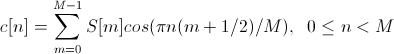

Получаем набор MFCC


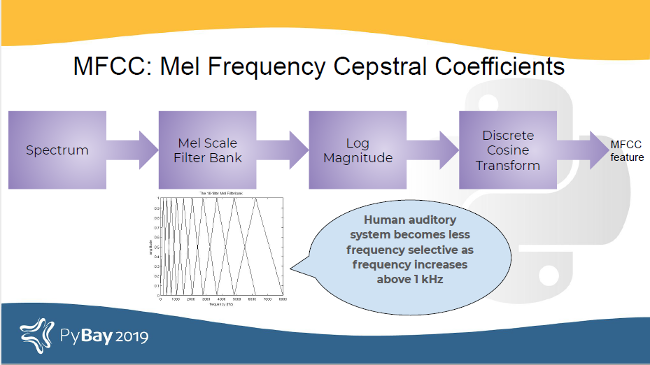

# Gammatone-frequency cepstral coefficients (GFCCs) Гамматон-частотные кепстральные коэффициенты

Еще один фильтр, вдохновленный человеческим слухом, — это набор фильтров Gammatone. Этот банк фильтров используется в качестве внешнего моделирования улитки. 

Eго цель — воспроизвести то, как мы слышим.

GFCC формируются путем пропускания спектра через блок фильтров Gammatone с последующим сжатием громкости и DCT. Первые (приблизительно) 22 функции называются GFCC. GFCC имеют ряд применений в обработке речи, например, идентификация говорящего.


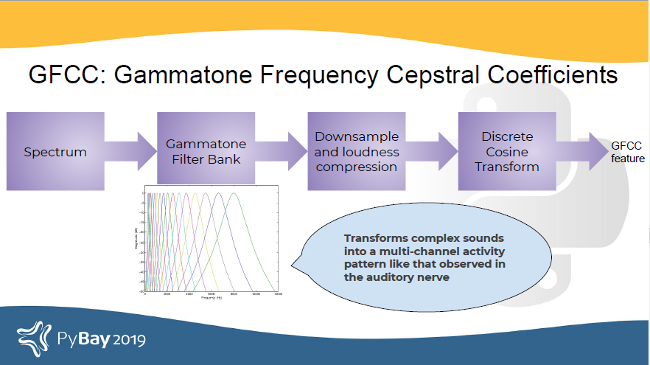

# Создание классификатора

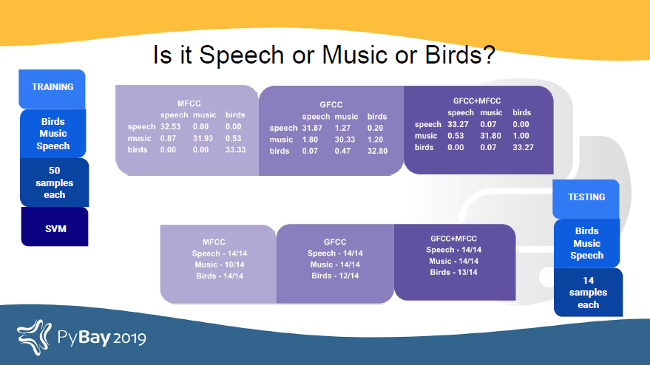

In [118]:
import librosa

samples, sample_rate = librosa.load("data/Alesis-S4-Plus-Clean-Gtr-C4.wav")

y = samples
sr = sample_rate
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=10)

In [121]:
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=20000)


c:\projects\ml-repos\perm_ml_ai\perm__ml_ai\.venv\lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


[Text(0.5, 1.0, 'MFCC')]

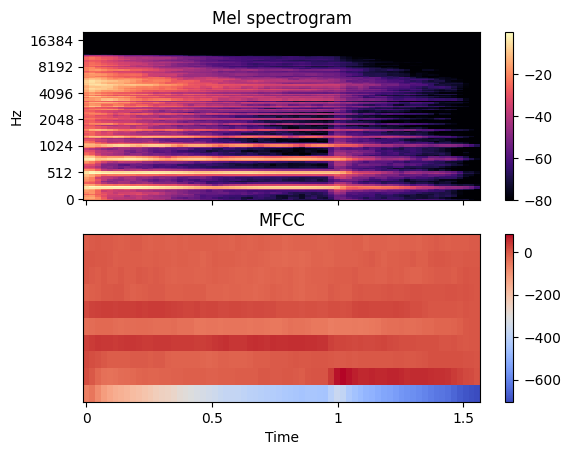

In [122]:
fig, ax = plt.subplots(nrows=2, sharex=True)
img = librosa.display.specshow(librosa.power_to_db(S, ref=np.max),
                               x_axis='time', y_axis='mel', fmax=20000,
                               ax=ax[0])
fig.colorbar(img, ax=[ax[0]])
ax[0].set(title='Mel spectrogram')
ax[0].label_outer()
img = librosa.display.specshow(mfccs, x_axis='time', ax=ax[1])
fig.colorbar(img, ax=[ax[1]])
ax[1].set(title='MFCC')

In [123]:
mfccs

array([[-6.47136078e+01, -4.78177605e+01, -8.46887360e+01,
        -1.19204720e+02, -1.38160156e+02, -1.54314514e+02,
        -1.62488007e+02, -1.72761154e+02, -1.85436768e+02,
        -1.95935211e+02, -2.09219788e+02, -2.22040726e+02,
        -2.37154755e+02, -2.47195663e+02, -2.54786835e+02,
        -2.68124115e+02, -2.87524841e+02, -2.98178589e+02,
        -3.09684235e+02, -3.21355560e+02, -3.31986176e+02,
        -3.43230133e+02, -3.53285675e+02, -3.69344330e+02,
        -3.77011292e+02, -3.78594269e+02, -3.82183350e+02,
        -3.89781891e+02, -3.98011932e+02, -4.03105743e+02,
        -4.07830872e+02, -4.14831360e+02, -4.17909393e+02,
        -4.23739899e+02, -4.31942719e+02, -4.37953979e+02,
        -4.44094513e+02, -4.47536102e+02, -4.41331207e+02,
        -4.41381805e+02, -4.44717712e+02, -4.49471558e+02,
        -4.05804352e+02, -3.64767212e+02, -3.85174500e+02,
        -4.29558441e+02, -4.54467590e+02, -4.72341461e+02,
        -4.91592896e+02, -4.96744995e+02, -5.14830811e+0

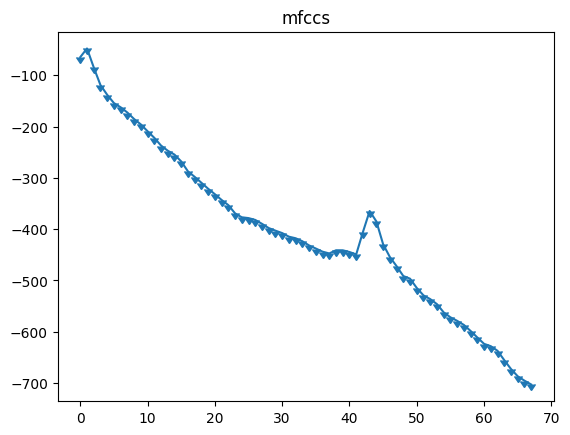

In [125]:
s = mfccs[0:1,:][0,:]
t = [*range(len(s))]
plt.plot(t,  s.reshape(68,1),marker=matplotlib.markers.CARETDOWNBASE)
plt.title('mfccs')
plt.show()

In [105]:
from python_speech_features import mfcc
from python_speech_features import logfbank
import scipy.io.wavfile as wav

(rate,sig) = wav.read("data/1980s-Casio-Violin-C5.wav")
mfcc_feat = mfcc(sig,rate)
fbank_feat = logfbank(sig,rate)

print(fbank_feat[1:3,:])

C:\Users\Mi\AppData\Local\Temp\ipykernel_62372\1104492666.py:5: WavFileWarning: Chunk (non-data) not understood, skipping it.
  (rate,sig) = wav.read("data/1980s-Casio-Violin-C5.wav")


[[ 7.04393625  5.14633017  6.35264354  6.88737254  6.12846521  7.69205614
  10.43077542  9.34865166  8.22189768 10.7505504  10.77283741  8.90154949
  11.60664089  9.74972658 10.82009684  8.81627423  9.88178822 11.01803061
  11.33282632 11.00119689 10.912455   11.08372085 11.28432751 11.89609813
  11.72067814 12.16916097]
 [ 9.12928039  8.01368806  8.05886038 11.05381835 11.49725941 10.46544028
  13.26328373 13.00222807 14.35938474 14.36052161 15.04937165 15.19409706
  15.10858721 14.6780638  13.64595965 14.19873476 15.57154442 16.26185827
  15.95818141 14.65637684 16.05026492 16.51119276 15.36320247 16.53394214
  15.93621915 16.32239956]]
